In [33]:
import numpy as np
import pickle
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

In [12]:
# Define the file paths
file_paths = ["index_history.pkl", "saved_indexes.pkl", "saved_symbols.pkl", "ticker_history.pkl", "event_clean.pkl"]

# Load the data from each file
data_dict = {}

for path in file_paths:
    with open(path, "rb") as file:
        data = pickle.load(file, encoding='latin1')
        data_dict[path] = data

# Access the loaded data
index_history = data_dict["index_history.pkl"]
saved_indices = data_dict["saved_indexes.pkl"]
saved_tickers = data_dict["saved_symbols.pkl"]
ticker_history = data_dict["ticker_history.pkl"]
earning_history = data_dict["event_clean.pkl"]

# Print some information about the loaded data (optional)
print("Index History:", type(index_history), len(index_history))
print("Saved Indices:", type(saved_indices), len(saved_indices))
print("Saved Tickers:", type(saved_tickers), len(saved_tickers))
print("Ticker History:", type(ticker_history), len(ticker_history))
print("Earning History:", type(earning_history), len(earning_history))

Index History: <class 'dict'> 20
Saved Indices: <class 'list'> 20
Saved Tickers: <class 'list'> 101
Ticker History: <class 'dict'> 101
Earning History: <class 'dict'> 101


In [13]:
# Define the function that adds log_returns, To Do: Turn this into a pre-processing class

def add_log_returns(df):
    if np.sum(df['Open'].isna().values) != 0:
        df['Open'].fillna(method='bfill', inplace=True)
    opens = df['Open'].values
    df['log_returns'] = np.log10(opens/opens[0])
    df['date'] = df.index.date

In [14]:
# Only AAPL has a NaN opening

for index in index_history:
    add_log_returns(index_history[index])
    

for ticker in ticker_history:
    add_log_returns(ticker_history[ticker])

In [15]:
# Double Check for missing values

for ticker in ticker_history:
    if ticker_history[ticker]['log_returns'][0] == np.nan:
        print(ticker)

for index in index_history:
    if index_history[index]['log_returns'][0] == np.nan:
        print(index)

In [16]:
# Store binary indicator for surprise

def add_surprise_label(df):
    df['s_label'] = df['Surprise(%)'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
# Running the function

for ticker in earning_history:
    add_surprise_label(earning_history[ticker])

In [18]:
# Gathers 1_mo history(ies) of the ticker df1 given earnings data df2.

def gather_1mo_history(df1, df2):

    result = []
    for date in df2.index:
        start_date = date - pd.Timedelta(days=31)
        filtered_df1 = df1.loc[start_date:date]
        
        if len(filtered_df1) < 31:
            additional_rows_needed = 31 - len(filtered_df1)
            additional_rows = df1.loc[:start_date].tail(additional_rows_needed)
            filtered_df1 = pd.concat([additional_rows, filtered_df1])
        
        filtered_df1 = filtered_df1.iloc[-31:]
        
        open_values = filtered_df1['Open'].values
        result.append(open_values)
        
    result_df = pd.DataFrame(result, index=df2.index, columns=[f'X_{i+1}' for i in range(31)])
    result_df = result_df.dropna()
    result_df = np.log10(result_df.div(result_df.iloc[:, -1], axis=0))
    result_df = pd.merge(result_df, df2['s_label'], left_index=True, right_index=True, how='left')
    result_df.index = result_df.index.tz_convert('UTC')
    result_df.index = result_df.index.date 
    return result_df

In [32]:
# Given any two dfs, merge based on concurrent dates

def get_concurrent_prices(df1, df2):
    return pd.merge(df1, df2, on='date', how='inner', suffixes=('_1', '_2'))

# Plot correlations between histories

def check_correlation(df1, df2, plot=True, label1='X', label2='Y', color='b', name=None):
    df = get_concurrent_prices(df1, df2)
    correlation = df[['log_returns_1', 'log_returns_2']].corr().loc['log_returns_1', 'log_returns_2']

    fig, axes = plt.subplots(1, 1, figsize=(6, 4))

    sns.regplot(x='log_returns_1', y='log_returns_2', data=df, ax=axes, label='corr={:.2f}'.format(correlation), color=color, scatter_kws={'alpha':0.1, 's':15}, line_kws={'ls':'--', 'lw':1.5})
    axes.legend(frameon=False)
    axes.set_xlabel(label1, fontsize=12, fontfamily='serif')
    axes.set_ylabel(label2, fontsize=12, fontfamily='serif')
    plt.tight_layout()

    if name is not None:
        plt.savefig(name+'.png', dpi=300, bbox_inches='tight')

    plt.show()

In [19]:
# Get X, Y for our fitting

def return_variables(ticker):
    df1=ticker_history[ticker]
    df2=earning_history[ticker]
    df=gather_1mo_history(df1, df2)
    return df.iloc[:, :30].values, df['s_label'].values

In [28]:
for i, ticker in enumerate(ticker_history):
    x, y = return_variables(ticker)
    if i==0:
        X = x
        Y = y
    else:
        X = np.concatenate((X, x))
        Y = np.concatenate((Y, y))

In [31]:
Y = np.nan_to_num(Y, nan=0)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.57      0.33        61
           1       0.87      0.59      0.70       283

    accuracy                           0.59       344
   macro avg       0.55      0.58      0.52       344
weighted avg       0.75      0.59      0.64       344



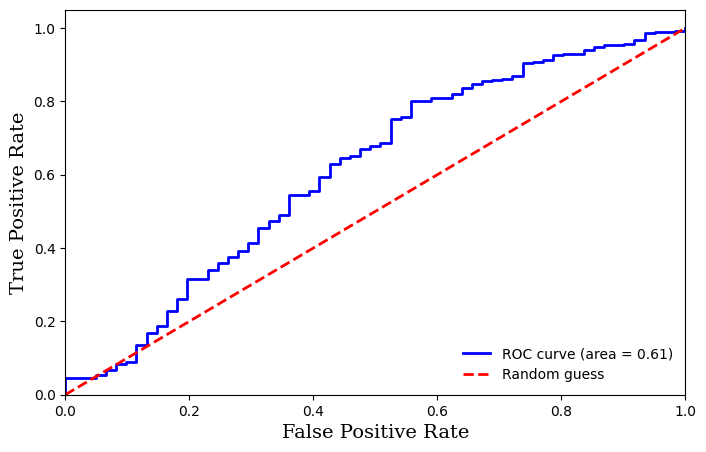

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=14, fontfamily='serif')
plt.ylabel('True Positive Rate', fontsize=14, fontfamily='serif')

plt.legend(loc='lower right', frameon=False)

plt.savefig('roc_1.png', dpi=300, bbox_inches='tight')

plt.show()